# Dataset Redone
---
[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu
---
## Summary

We have discovered several issues with our splits:
- Contentment is a dominating force which rebalancing does not help
- Minority emotions are severely underclassed

This required us to completely re-examine how we are treating this dataset. To combat these issues we decided on the following:
1. One utterance per painting sampled with a weight on utterance length from the majority emotion (text and image modalities will have equal datapoints)
2. Rebalance such that `disgust` and `anger` are grouped together; more statistical power
3. Rebalace such that `excitement` and `amusement`; to keep it 3 positive and 3 negative emotions
4. Pre-downsample `contentment`; it is just too dominating
5. Downsize to have approximately 19k total samples, keeping data proportions; this makes it easier for us to train models
6. Perform data splits, stratified to preserve class balancing for the test set
---
## Setup
### Necessary Imports

In [82]:
from nltk import word_tokenize
from sklearn.model_selection import StratifiedShuffleSplit

import numpy as np
import pandas as pd

### Settings

In [46]:
# Turn this off
%pprint
pd.set_option('display.max_columns', None)

Pretty printing has been turned ON


### Globals

In [47]:
DATA = "../data/splits.csv"
SEED = 42

### Dataset

In [48]:
# Start from here since we already filtered out minority emotions
df = pd.read_csv(DATA, index_col=False).drop(columns=["split", "count", "repetition"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196844 entries, 0 to 196843
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   painting   196844 non-null  object 
 1   artist     196844 non-null  object 
 2   art_style  196844 non-null  object 
 3   year       114631 non-null  float64
 4   utterance  196844 non-null  object 
 5   emotion    196844 non-null  object 
dtypes: float64(1), object(5)
memory usage: 9.0+ MB


---
## 1. One Utterance per Painting

In [49]:
# This should stay the same after our operation
UNIQUE = len(df["painting"].unique())
UNIQUE

71219

In [50]:
# Get utterance length
df["len"] = df["utterance"].map(lambda x: len(word_tokenize(x)))

In [51]:
df.iloc[df["len"].idxmax(), :]

painting                         marc-chagall_the-fiddler-1913
artist                                            marc-chagall
art_style                                               Cubism
year                                                    1913.0
utterance    the white snow is a great backdrop for this, a...
emotion                                              amusement
len                                                        226
Name: 53176, dtype: object

In [52]:
df = df.sort_values(by=["painting"])
df = df.groupby(["painting"]).sample(1, weights=df["len"], random_state=SEED).reset_index(drop=True)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71219 entries, 0 to 71218
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   painting   71219 non-null  object 
 1   artist     71219 non-null  object 
 2   art_style  71219 non-null  object 
 3   year       41727 non-null  float64
 4   utterance  71219 non-null  object 
 5   emotion    71219 non-null  object 
 6   len        71219 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.8+ MB


---
## 2. Merge `disgust` and `anger`

Name will simply be `disgust-anger`.

In [54]:
df["emotion"] = df["emotion"].map(lambda x: "disgust-anger" if x in ["disgust", "anger"] else x)

In [55]:
df["emotion"].unique()

array(['fear', 'amusement', 'sadness', 'contentment', 'excitement', 'awe',
       'something else', 'disgust-anger'], dtype=object)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71219 entries, 0 to 71218
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   painting   71219 non-null  object 
 1   artist     71219 non-null  object 
 2   art_style  71219 non-null  object 
 3   year       41727 non-null  float64
 4   utterance  71219 non-null  object 
 5   emotion    71219 non-null  object 
 6   len        71219 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.8+ MB


---
## 3. Merge `excitement` and `amusement`

Name will simply be `excitement-amusement`.

In [57]:
df["emotion"] = df["emotion"].map(lambda x: "excitement-amusement" if x in ["excitement", "amusement"] else x)

In [58]:
df["emotion"].unique()

array(['fear', 'excitement-amusement', 'sadness', 'contentment', 'awe',
       'something else', 'disgust-anger'], dtype=object)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71219 entries, 0 to 71218
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   painting   71219 non-null  object 
 1   artist     71219 non-null  object 
 2   art_style  71219 non-null  object 
 3   year       41727 non-null  float64
 4   utterance  71219 non-null  object 
 5   emotion    71219 non-null  object 
 6   len        71219 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.8+ MB


---
## 4. Downsample `contentment`

Let's figure out how much to downsample by

<Axes: xlabel='emotion'>

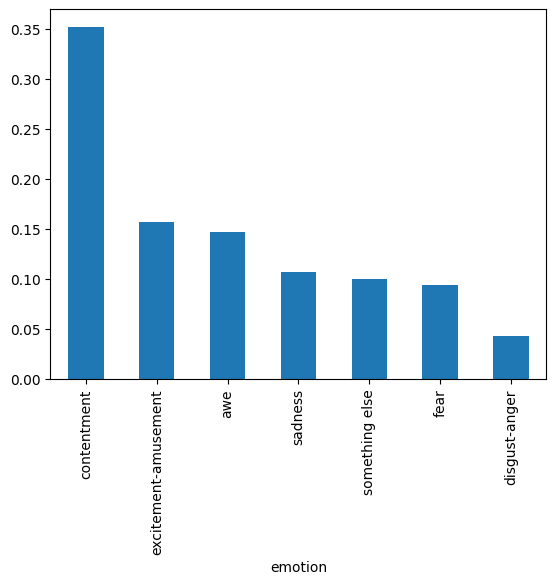

In [62]:
df["emotion"].value_counts(normalize=True).plot(kind="bar")

In [63]:
len(df[df["emotion"] == "contentment"])

25074

Downsample by a factor of 2.5.

In [66]:
cont_sample = df["painting"].isin(df[df["emotion"] == "contentment"].sample(frac=0.4, random_state=SEED)["painting"])
other = df["emotion"] != "contentment"
mask = cont_sample | other
mask

0         True
1         True
2         True
3         True
4         True
         ...  
71214    False
71215     True
71216     True
71217    False
71218     True
Length: 71219, dtype: bool

In [67]:
df = df[mask]

<Axes: xlabel='emotion'>

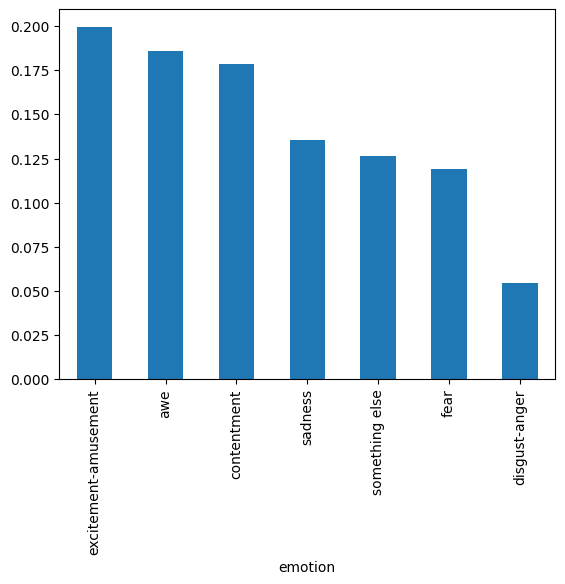

In [68]:
df["emotion"].value_counts(normalize=True).plot(kind="bar")

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56175 entries, 0 to 71218
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   painting   56175 non-null  object 
 1   artist     56175 non-null  object 
 2   art_style  56175 non-null  object 
 3   year       33168 non-null  float64
 4   utterance  56175 non-null  object 
 5   emotion    56175 non-null  object 
 6   len        56175 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 3.4+ MB


In [70]:
# Add the factor column
df["factor"] = df["emotion"].map(lambda x: 2.5 if x == "contentment" else 1.0)

In [76]:
df.sample(15, random_state=SEED)

,painting,artist,art_style,year,utterance,emotion,len,factor
15779,edward-burne-jones_the-soul-attains,edward-burne-jones,Romanticism,NaN,this picture is beautiful with how realistic b...,awe,13,1.0
29327,iosif-iser_seated-woman-with-yellow-jacket,iosif-iser,Expressionism,NaN,the woman looks angry. the detail in this is i...,awe,26,1.0
28949,ilya-repin_portrait-of-the-author-leonid-andre...,ilya-repin,Realism,1904.0,he looks like he is thinking of someone he lost.,sadness,11,1.0
70114,william-merritt-chase_the-lake-for-miniature-y...,william-merritt-chase,Impressionism,NaN,the colors used to illustrate that it's a nice...,awe,12,1.0
6453,barnett-newman_onement-i-1948,barnett-newman,Color_Field_Painting,1948.0,the orange line is slightly sloppy creating a ...,fear,26,1.0
54470,pierre-alechinsky_pleasant-surrounding-un-bon-...,pierre-alechinsky,Expressionism,1962.0,the voices in his head have finally gotten out,fear,9,1.0
34240,joan-miro_portrait-of-a-spanish-dancer,joan-miro,Cubism,NaN,the colors as well as the shapes used to shape...,awe,19,1.0
58265,raphael_isaac-and-rebecca-spied-upon-by-abimel...,raphael,High_Renaissance,1519.0,the white specs all over the painting remind m...,awe,27,1.0
65802,vasily-surikov_portrait-of-e-n-sabashnikova-1907,vasily-surikov,Realism,1907.0,feel neutral due to the dull colors of the dre...,something else,12,1.0
4609,annibale-carracci_the-butcher-s-shop,annibale-carracci,Baroque,NaN,it's kind of gross to look at meat hanging up ...,disgust-anger,21,1.0


---
## 5. Dataset Downsize

In [77]:
FACTOR = 2.956578947
# Truly random to not make it too biased towards longer descriptions
down_df = df.groupby(["emotion"]).sample(frac=1/FACTOR, random_state=SEED).reset_index(drop=True)

In [80]:
down_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19000 entries, 0 to 18999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   painting   19000 non-null  object 
 1   artist     19000 non-null  object 
 2   art_style  19000 non-null  object 
 3   year       11221 non-null  float64
 4   utterance  19000 non-null  object 
 5   emotion    19000 non-null  object 
 6   len        19000 non-null  int64  
 7   factor     19000 non-null  float64
dtypes: float64(2), int64(1), object(5)
memory usage: 1.2+ MB


<Axes: xlabel='emotion'>

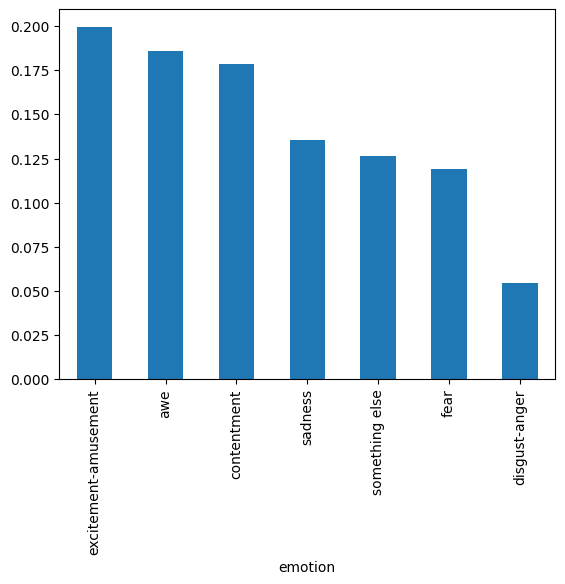

In [81]:
down_df["emotion"].value_counts(normalize=True).plot(kind="bar")

---
## Stratified Splits

In [85]:
down_df.head(10)

,painting,artist,art_style,year,utterance,emotion,len,factor
0,lorenzo-lotto_st-jerome-in-the-desert-1,lorenzo-lotto,High_Renaissance,NaN,very powerful and strong subjects. love the u...,awe,23,1.0
1,john-singer-sargent_fumee-d-ambre-gris-1880,john-singer-sargent,Realism,1880.0,the detail in the woman's attire is absolutely...,awe,11,1.0
2,giovanni-boldini_madame-michelham-1913,giovanni-boldini,Realism,1913.0,the woman's clothing has wonderful curves and ...,awe,11,1.0
3,hans-baldung_adoration-of-the-magi-1507,hans-baldung,Northern_Renaissance,1507.0,a precious baby is given all the attention in ...,awe,17,1.0
4,fyodor-bronnikov_abandoned-1873,fyodor-bronnikov,Realism,1873.0,this is beautifully drawn and i feel awe as i ...,awe,33,1.0
5,mabuse_portrait-of-chancellor-jean-carondelet-...,mabuse,Northern_Renaissance,1517.0,he has an expression of deep understanding and...,awe,19,1.0
6,ogata-gekko_odori-dancer,ogata-gekko,Ukiyo_e,NaN,the japanese writing evokes feelings of exotic...,awe,10,1.0
7,correggio_madonna-with-st-george-1532,correggio,Mannerism_Late_Renaissance,1532.0,the figures are so detailed and there is so mu...,awe,27,1.0
8,edouard-manet_the-rest-portrait-of-berthe-mori...,edouard-manet,Impressionism,1870.0,the womans bright white dress reminds me of fr...,awe,13,1.0
9,filippo-lippi_annunciation-1450,filippo-lippi,Early_Renaissance,1450.0,this painting has deep spiritual meaning for m...,awe,11,1.0


In [120]:
strat = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=SEED)
test_strat = StratifiedShuffleSplit(n_splits=1, test_size=1/3, random_state=SEED)

In [121]:
train_ind, test_ind = next(strat.split(np.zeros(len(down_df)), down_df["emotion"]))
print(train_ind)

[ 3724  3759 13395 ... 14324   482  6913]


In [122]:
# Get the splits for the valid split
test_df = down_df.iloc[test_ind, :]
test_ind, valid_ind = next(test_strat.split(np.zeros(len(test_df)), test_df["emotion"]))
print(valid_ind)

[4934 3875 3340 ... 4831 1390 2343]


In [123]:
# Sanity check
set(test_ind).intersection(set(valid_ind))

set()

In [124]:
train_df = down_df.iloc[train_ind, : ].copy()

test_df.reset_index(drop=True, inplace=True)
valid_df = test_df.iloc[valid_ind, : ].copy()
test_df = test_df.iloc[test_ind, : ].copy()

In [125]:
train_df["split"] = "TRAIN"
valid_df["split"] = "VALID"
test_df["split"] = "TEST"

final_df = pd.concat([train_df, valid_df, test_df])

In [126]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19000 entries, 3724 to 5021
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   painting   19000 non-null  object 
 1   artist     19000 non-null  object 
 2   art_style  19000 non-null  object 
 3   year       11221 non-null  float64
 4   utterance  19000 non-null  object 
 5   emotion    19000 non-null  object 
 6   len        19000 non-null  int64  
 7   factor     19000 non-null  float64
 8   split      19000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.4+ MB


<Axes: xlabel='split,emotion'>

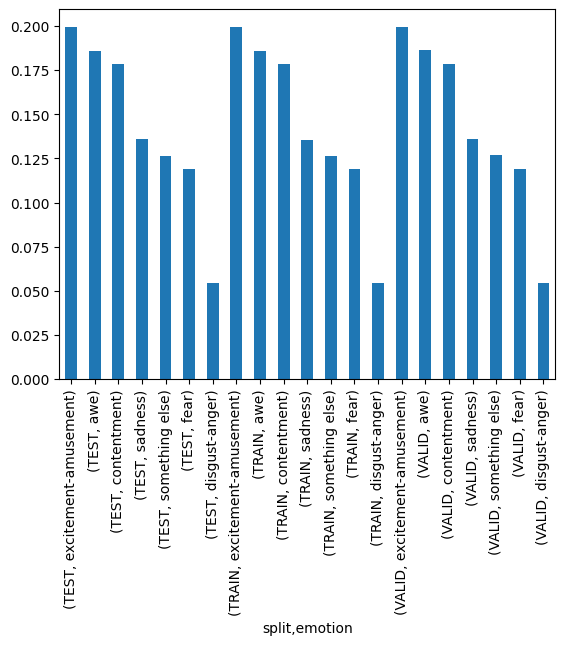

In [136]:
final_df.groupby(["split"])["emotion"].value_counts(normalize=True).plot(kind="bar")

In [135]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19000 entries, 0 to 18999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   painting   19000 non-null  object 
 1   artist     19000 non-null  object 
 2   art_style  19000 non-null  object 
 3   year       11221 non-null  float64
 4   utterance  19000 non-null  object 
 5   emotion    19000 non-null  object 
 6   len        19000 non-null  int64  
 7   factor     19000 non-null  float64
 8   split      19000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.3+ MB


In [133]:
final_df.sample(10, random_state=SEED)

,painting,artist,art_style,year,utterance,emotion,len,factor,split
7592,caravaggio_portrait-of-alof-de-wignacourt-and-...,caravaggio,Baroque,1608.0,this photo reminds me of watching game of thro...,awe,19,1.0,TRAIN
12051,milton-avery_two-women-1950,milton-avery,Expressionism,1950.0,i'm not a fan of this person's art style. the ...,disgust-anger,28,1.0,TRAIN
17353,utagawa-kuniyoshi_kotenrai-ryioshin-loading-a-...,utagawa-kuniyoshi,Ukiyo_e,NaN,the colors are beautiful the orange reds and b...,excitement-amusement,33,1.0,VALID
17873,gustave-moreau_perseus-and-andromeda,gustave-moreau,Symbolism,NaN,a naked woman looks on as good and evil battle...,fear,16,1.0,VALID
18496,aubrey-beardsley_the-mirror-of-love,aubrey-beardsley,Art_Nouveau_Modern,NaN,"a sexy print, a juxtaposition of someone comfo...",excitement-amusement,22,1.0,VALID
16855,john-trumbull_the-surrender-of-lord-cornwallis...,john-trumbull,Romanticism,1820.0,the sight of soldiers lined up makes for an ex...,excitement-amusement,14,1.0,TRAIN
8723,bertalan-por_woman-with-a-hat-1905,bertalan-por,Post_Impressionism,1905.0,the expression on the lady's face makes me sad.,sadness,11,1.0,TRAIN
16053,marc-chagall_the-sacrifice-offered-by-elijah-i...,marc-chagall,Naive_Art_Primitivism,NaN,"the black and white contrast, the dark figure ...",fear,32,1.0,TRAIN
9913,hans-holbein-the-younger_oberried-altarpiece-l...,hans-holbein-the-younger,Northern_Renaissance,1522.0,looks like a baptism. i like the architecture ...,contentment,13,2.5,TRAIN
16805,dante-gabriel-rossetti_the-blue-closet-1857,dante-gabriel-rossetti,Romanticism,1857.0,"there faces look amusing, a little bit of disg...",excitement-amusement,20,1.0,TRAIN


In [137]:
print(len(final_df[final_df["split"] == "TRAIN"]))
print(len(final_df[final_df["split"] == "VALID"]))
print(len(final_df[final_df["split"] == "TEST"]))

13300
1900
3800


In [132]:
final_df.sort_values(by="split", inplace=True, ignore_index=True)

In [134]:
# Save it
final_df.to_csv("../data/final-splits.csv", index=False, header=True)